**In this image classification I train the model from images of Cats, Dogs and Pandas arranged into separate folders in Google Drive. I mounted the google drive through code and then reads files from drive directly. We need to train the model only once and then we can use that for prediction. So I check if there is a model exists already if not i train the model and create one else I use the already trained model to predict more photos**

In [92]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import the necessary packages
import matplotlib
matplotlib.use("Agg")
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
from google.colab.patches import cv2_imshow

In [0]:
# !unzip "/content/drive/My Drive/Data Sets/animals/animals.zip" -d "/content/drive/My Drive/Data Sets/animals"

In [0]:
# Initialize the variables

VARIABLE_DICT = {'vgg': {
	"IMAGE_PATH":"/content/drive/My Drive/Data Sets/animals/animals",
	"PREDICT_IMAGE_FOLDER": "/content/drive/My Drive/Data Sets/animals/validation",
	"MODEL_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/smallvggnet.model",
	"LABEL_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/smallvggnet_lb.pickle",
	"PLOT_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/smallvggnet_plot.png",
	"WIDTH": 64,
	"HEIGHT": 64,
	"DEPTH": 3,
	"FLATTEN": False
},
	'nn': {
	"IMAGE_PATH":"/content/drive/My Drive/Data Sets/animals/animals",
	"PREDICT_IMAGE_FOLDER": "/content/drive/My Drive/Data Sets/animals/validation",
	"MODEL_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/simple_nn.model",
	"LABEL_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/simple_nn_lb.pickle",
	"PLOT_PATH":"/content/drive/My Drive/Colab Notebooks/Projects/data/simple_nn_plot.png",
	"WIDTH": 32,
	"HEIGHT": 32,
	"DEPTH": 3,
	"FLATTEN": True
	}}



# model = 'vgg'
model = 'nn'
globals().update(VARIABLE_DICT[model])

In [0]:
# initialize our initial learning rate, # of epochs to train for,
# and batch size
INIT_LR = 0.01
EPOCHS = 75
BS = 32


In [0]:
def build(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1

	# CONV => RELU => POOL layer set
	model.add(Conv2D(32, (3, 3), padding="same",
					 input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

	# (CONV => RELU) * 2 => POOL layer set
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

	# (CONV => RELU) * 3 => POOL layer set
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

	# first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(512))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))

	# return the constructed network architecture
	return model


In [0]:
def get_data_label_from_image_path(image_folder_path, train=True):
  print("[INFO] loading images...")
  data = []
  labels = []
  image_copy_list = []

  # grab the image paths and randomly shuffle them
  image_path_list = sorted(list(paths.list_images(image_folder_path)))
  random.seed(42)
  random.shuffle(image_path_list)

  # loop over the input images
  for image_path in image_path_list:
    print(f'Processing file: {image_path}') if not train else None
    # load the image, resize it to 64x64 pixels (the required input)
    # spatial dimensions of SmallVGGNet), and store the image in the
    # data list
    image = cv2.imread(image_path)
    image_copy_list.append(image.copy())
    image = cv2.resize(image, (WIDTH, HEIGHT))
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = image_path.split(os.path.sep)[-2]
    labels.append(label)

  # scale the raw pixel intensities to the range [0, 1]
  data = np.array(data, dtype="float") / 255.0
  labels = np.array(labels)

  # labels.append(label)
  if train:
    return data, labels 
  else:
    return data, labels, image_copy_list 


In [0]:
def prepare_train_test_data(IMAGE_PATH):  
  # initialize the data and labels
  data, labels = get_data_label_from_image_path(IMAGE_PATH)
  
  # partition the data into training and testing splits using 75% of
  # the data for training and the remaining 25% for testing
  (trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)

  # convert the labels from integers to vectors (for 2-class, binary
  # classification you should use Keras' to_categorical function
  # instead as the scikit-learn's LabelBinarizer will not return a
  # vector)
  lb = LabelBinarizer()
  trainY = lb.fit_transform(trainY)
  testY = lb.transform(testY)

  return trainX, testX, trainY, testY

In [0]:
def training_model(model, aug, trainX, testX, trainY, testY):
  # initialize the model and optimizer (you'll want to use
  # binary_crossentropy for 2-class classification)
  print("[INFO] training network...")
  opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

  # train the network
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS)

  # evaluate the network
  print("[INFO] evaluating network...")
  predictions = model.predict(testX, batch_size=32)
  print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

  # plot the training loss and accuracy
  N = np.arange(0, EPOCHS)
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(N, H.history["loss"], label="train_loss")
  plt.plot(N, H.history["val_loss"], label="val_loss")
  plt.plot(N, H.history["acc"], label="train_acc")
  plt.plot(N, H.history["val_acc"], label="val_acc")
  plt.title("Training Loss and Accuracy (SmallVGGNet)")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.savefig(PLOT_PATH)

  # save the model and label binarizer to disk
  print("[INFO] serializing network and label binarizer...")
  model.save(MODEL_PATH)
  f = open(LABEL_PATH, "wb")
  f.write(pickle.dumps(lb))
  f.close()

In [0]:
def train_model():
  trainX, testX, trainY, testY = prepare_train_test_data(IMAGE_PATH)

  # construct the image generator for data augmentation
  aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

  # initialize our VGG-like Convolutional Neural Network
  model = build(width=WIDTH, height=HEIGHT, depth=DEPTH,
    classes=len(lb.classes_))
  
  training_model(model, aug, trainX, testX, trainY, testY)

In [0]:
def predict_new_images(PREDICT_IMAGE_FOLDER):  
  # load the model and label binarizer
  print(f"Predicting images from folder: {PREDICT_IMAGE_FOLDER}")
  model = load_model(MODEL_PATH)
  lb = pickle.loads(open(LABEL_PATH, "rb").read())

  data, labels, image_copies = get_data_label_from_image_path(PREDICT_IMAGE_FOLDER, train=False)

  for image, image_copy in zip(data, image_copies):
    print('inside for loop')
    if FLATTEN:
      image = image.flatten()
      image = image.reshape((1, image.shape[0]))

      # otherwise, we must be working with a CNN -- don't flatten the
      # image, simply add the batch dimension
    else:
      image = image.reshape((1, image.shape[0], image.shape[1],
      image.shape[2]))

    # make a prediction on the image
    preds = model.predict(image)
    print(f'Predicted for image')
    # find the class label index with the largest corresponding
    # probability
    i = preds.argmax(axis=1)[0]
    label = lb.classes_[i]

    # draw the class label + probability on the output image
    text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
    image_copy = cv2.putText(image_copy, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # show the output image
    # cv2.imshow("Image", output)
    cv2_imshow(image_copy)
    # cv2.waitKey(0)

In [0]:
def check_if_model_label_exists(file_path_list):
  for file_path in file_path_list:
    if not os.path.exists(file_path):
      print(f'File: {file_path} doesnt exist. Hence breaking')
      break
  else:
    return True

  return False

Model is trained already. We are lucky, we just need to load the mode and label then use that to predict each image
Predicting images from folder: /content/drive/My Drive/Data Sets/animals/validation


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[INFO] loading images...
Processing file: /content/drive/My Drive/Data Sets/animals/validation/dogs_00015.jpg
Processing file: /content/drive/My Drive/Data Sets/animals/validation/cats_00002.jpg
Processing file: /content/drive/My Drive/Data Sets/animals/validation/panda_00015.jpg
inside for loop
Predicted for image


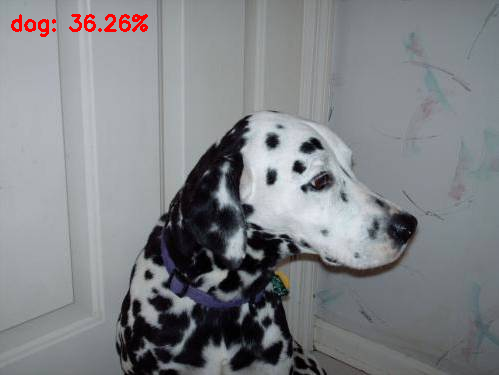

inside for loop
Predicted for image


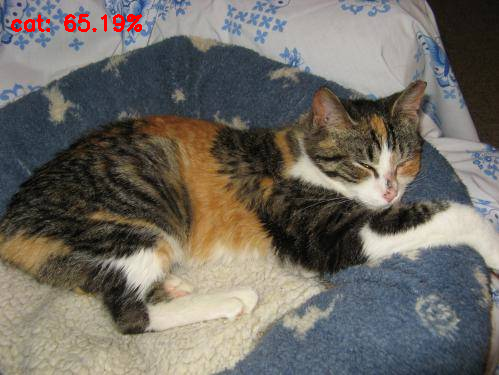

inside for loop
Predicted for image


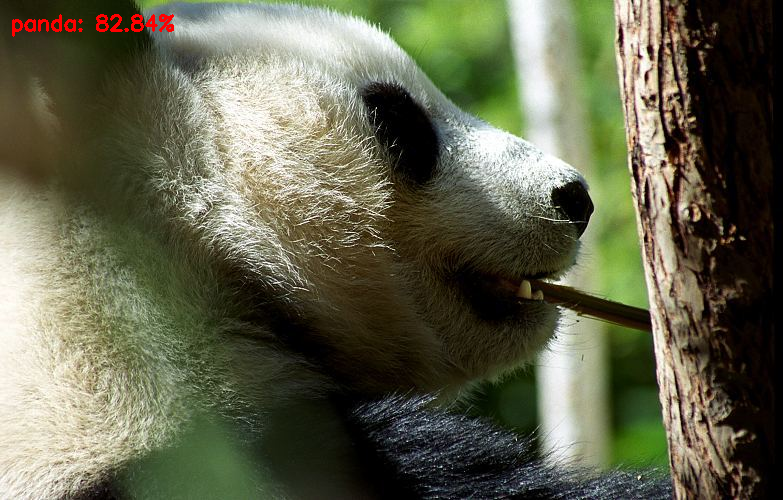

FINISHED


In [104]:
if not check_if_model_label_exists([MODEL_PATH, LABEL_PATH]):
  print("Model is not trained. Hence we need to train the model first which is bit time consuming")
  train_model()
else:
  print("Model is trained already. We are lucky, we just need to load the mode and label then use that to predict each image")

predict_new_images(PREDICT_IMAGE_FOLDER)
print('FINISHED')